In [133]:
import gym
from gym import spaces
from gym.utils import seeding

import pandas as pd
import numpy as np
import typing
from datetime import datetime

In [134]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False)


2020-11-16 13:43:03,721	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.


In [135]:
def load_data(
    price_source: str, 
    tickers: typing.List[str],
    start: datetime, 
    end: datetime, 
    features: typing.List[str],
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        for t in tickers:
            df1 = pd.read_csv("csvdata/{}.csv".format(t))
            df1['datetime'] = pd.to_datetime(df1['datetime'])
            df1 = df1[(df1['datetime']>=start) & (df1['datetime']<=end)]
            df1.set_index("datetime",inplace=True)
            selected_features = ['return','tcost'] + features
            feature_df.append(df1[selected_features])
            ref_df_columns = df1[selected_features].columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    # Imputer missing values with zeros 
    price_tensor = merged_df['return'].fillna(0.0).values
    tcost = merged_df['tcost'].fillna(0.0).values

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "data": merged_df.fillna(0.0).values,
        "pricedata": price_tensor,
        "tcost": tcost,
    }

from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
from sklearn.preprocessing import StandardScaler 

class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'],env_config['features'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        #self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        self.n_features = self.n_assets_fields * len(self.tickers)
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features,1), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        recent_series = pd.Series(self.log_return_series)[-100:]
        rolling_volatility = np.std(recent_series)
        self.metric = today_portfolio_return / rolling_volatility 
        reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        scaler = StandardScaler(with_mean=False)
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        observation = scaler.fit_transform(price_lookback)
        return observation.reshape((observation.shape[0], observation.shape[1], 1))
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        fees = np.array(list(fees) + [0.9995])
        tcost = turnover * np.log(fees)
        return tcost 

In [136]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [137]:
config = DEFAULT_CONFIG.copy()
config["num_workers"] = 15
config["num_envs_per_worker"] = 5
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 5000
config["batch_mode"] = "complete_episodes"
config["num_sgd_iter"] = 20
config["sgd_minibatch_size"] = 200
config['model']['dim'] = 10
config['model']['conv_filters'] = [[16, [2, 1], 2], [16, [2, 1], 2], [16, [2, 1], 5]]
config[
    "num_cpus_per_worker"
] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": [
        "BRK",
        "TLT",
        "GLD",
    ],
    "lookback": 10,
    "start": "2003-01-02",
    "end": "2019-12-31",
    "features": ["volatility_20", "skewness_20", "kurtosis_20"],
}


In [138]:
PPO_agent = PPOTrainer(config, Equitydaily)

2020-11-16 13:43:11,142	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [139]:
env = Equitydaily(config["env_config"] )

In [339]:
PPO_agent.restore('ppoagent/checkpoint_4963/checkpoint-4963')

2020-11-18 12:53:09,897	INFO trainable.py:481 -- Restored on 155.198.195.98 from checkpoint: ppoagent/checkpoint_4963/checkpoint-4963
2020-11-18 12:53:09,898	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 4963, '_timesteps_total': None, '_time_total': 121726.23110461235, '_episodes_total': 74445}


In [384]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    if env.index % 10 ==0:
        action = PPO_agent.compute_action(state)
    #action = np.array([1,1,1,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)


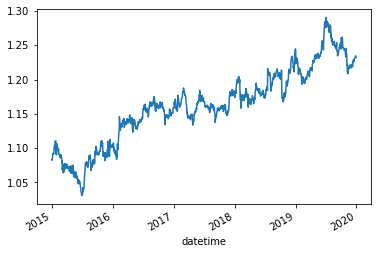

2020-11-18 18:14:54,387	INFO (unknown file):0 -- gc.collect() freed 16 refs in 0.5355427097529173 seconds


In [385]:
returns = pd.Series(env.log_return_series)
returns.index = env.dates[:-1]
returns.cumsum().loc['2015-01-01':].plot()

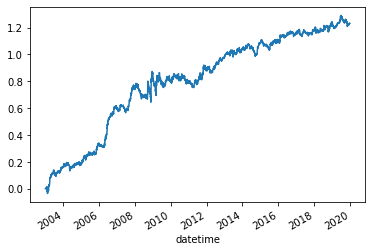

2020-11-18 18:15:24,439	INFO (unknown file):0 -- gc.collect() freed 16 refs in 0.470328014343977 seconds


In [386]:
returns = pd.Series(env.log_return_series)
returns.index = env.dates[:-1]
returns.cumsum().loc['2002-01-01':'2020-01-01'].plot()

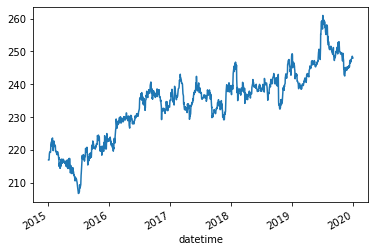

In [379]:
returns = pd.Series(env.metric_series)
returns.index = env.dates[:-1]
returns.cumsum().loc['2015-01-01':].plot()

In [380]:
position = pd.DataFrame(env.position_series)
position.index = env.dates[:-1]
position.columns = env.tickers + ['Cash']
position

,BRK,TLT,GLD,Cash
datetime,,,,
2003-01-02,0.000000,0.000000,0.000000,0.000000
2003-01-03,0.000000,0.000000,0.000000,0.000000
2003-01-06,0.000000,0.000000,0.000000,0.000000
2003-01-07,0.000000,0.000000,0.000000,0.000000
2003-01-08,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-12-23,0.111542,0.163153,0.711996,0.013309
2019-12-24,0.470097,0.453857,-0.024878,0.051168
2019-12-26,0.470097,0.453857,-0.024878,0.051168


2020-11-18 18:08:52,966	INFO (unknown file):0 -- gc.collect() freed 36 refs in 0.5366942118853331 seconds


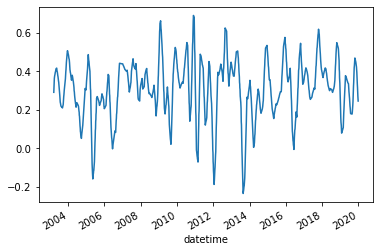

2020-11-18 18:08:32,863	INFO (unknown file):0 -- gc.collect() freed 38 refs in 0.5138390436768532 seconds


In [375]:
position['TLT'].rolling(50).mean().plot()

SAC

In [3]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [28]:
config = DEFAULT_CONFIG.copy()
config["num_workers"] = 10
config["num_envs_per_worker"] = 10

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 2500
config["timesteps_per_iteration"] = 10000
config["buffer_size"] = 20000
config["n_step"] = 10

config["Q_model"]["fcnet_hiddens"] = [10, 10]
config["policy_model"]["fcnet_hiddens"] = [10, 10]
config["num_cpus_per_worker"] = 2
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": ["QQQ", "EEM", "TLT", "SHY", "GLD", "SLV"],
    "lookback": 1,
    "start": "2007-01-02",
    "end": "2019-12-31",
}


In [29]:
def load_data(
    price_source="csvdata", tickers=["EEM", "QQQ"], start="2008-01-02", end="2010-01-02"
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        price_tensor = []
        for t in tickers:
            df1 = (
                pd.read_csv("csvdata/{}.csv".format(t)).set_index("date").loc[start:end]
            )
            feature_df.append(df1)
            price_tensor.append(
                df1["return"]
            )  # assumed to the be log return of the ref price
            ref_df_columns = df1.columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    price_tensor = np.vstack(price_tensor).transpose()

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "pricedata": price_tensor,
        "data": merged_df.values,
    }

class Equitydaily(gym.Env):
    def __init__(self, env_config):

        self.tickers = env_config["tickers"]
        self.lookback = env_config["lookback"]
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(
            env_config["pricing_source"],
            env_config["tickers"],
            env_config["start"],
            env_config["end"],
        )
        # Set the trading dates, features and price data
        self.dates = raw_data["dates"]
        self.fields = raw_data["fields"]
        self.pricedata = raw_data["pricedata"]
        self.featuredata = raw_data["data"]
        # Set up historical actions and rewards
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2
        self.n_assets_fields = len(self.fields)
        self.n_features = (
            self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics
        )  # reward function

        # Set up action and observation space
        # The last asset is cash
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(len(self.tickers) + 1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.lookback, self.n_features),
            dtype=np.float32,
        )

        self.reset()

    def step(self, action):

        ## Normalise action space
        normalised_action = action / np.sum(np.abs(action))

        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index, :]
        # transaction cost
        transaction_cost = self.transaction_cost(
            normalised_action, self.position_series[-1]
        )

        # Rebalancing
        self.position_series = np.append(
            self.position_series, [normalised_action], axis=0
        )
        # Portfolio return
        today_portfolio_return = np.sum(
            normalised_action[:-1] * next_day_log_return
        ) + np.sum(transaction_cost)
        self.log_return_series = np.append(
            self.log_return_series, [today_portfolio_return], axis=0
        )

        # Calculate reward
        # Need to cast log_return in pd series to use the functions in empyrical
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin:
            self.metric = annual_return(whole_series) + 0.5 * max_drawdown(whole_series)
        else:
            self.metric = (
                annual_return(whole_series)
                + 0.5 * max_drawdown(whole_series) * live_days / burnin
            )
        reward = self.metric - self.metric_series[-1]
        # reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)

        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0] - 2:
            done = True

        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()

        return self.observation, reward, done, {"current_price": next_day_log_return}

    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback, self.n_assets))
        self.metric = 0
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation

    def get_observation(self):
        price_lookback = self.featuredata[self.index - self.lookback : self.index, :]
        metrics = np.vstack(
            (
                self.log_return_series[self.index - self.lookback : self.index],
                self.metric_series[self.index - self.lookback : self.index],
            )
        ).transpose()
        positions = self.position_series[self.index - self.lookback : self.index]
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation

    # 0.05% t-cost for institutional portfolios
    def transaction_cost(
        self,
        new_action,
        old_action,
    ):
        turnover = np.abs(new_action - old_action)
        fees = 0.9995
        tcost = turnover * np.log(fees)
        return tcost


In [30]:
SAC_agent = SACTrainer(config, Equitydaily)

2020-11-06 10:29:38,891	WARNING sac_tf_policy.py:36 -- When not using a state-preprocessor with SAC, `fcnet_hiddens` will be set to an empty list! Any hidden layer sizes are defined via `policy_model.fcnet_hiddens` and `Q_model.fcnet_hiddens`.
2020-11-06 10:29:41,945	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [31]:
env = Equitydaily(config["env_config"])

In [54]:
SAC_agent.restore('sacagent/checkpoint_14083/checkpoint-14083')

2020-11-06 16:46:59,135	INFO trainable.py:481 -- Restored on 155.198.195.98 from checkpoint: sacagent/checkpoint_14083/checkpoint-14083
2020-11-06 16:46:59,136	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 14083, '_timesteps_total': None, '_time_total': 58403.04395079613, '_episodes_total': 62200}


In [71]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    if env.index % 5 ==0:
        action = SAC_agent.compute_action(state)
    #action = np.array([0,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)



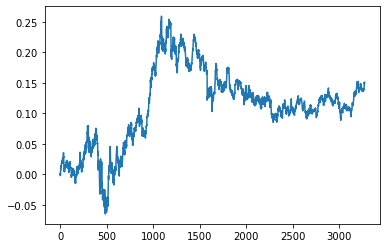

In [72]:
pd.Series(env.log_return_series).cumsum().plot()

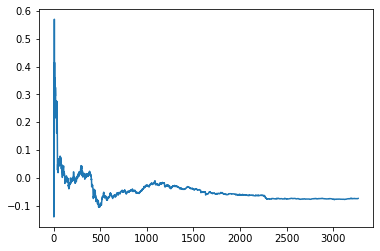

In [73]:
pd.Series(reward_list).cumsum().plot()

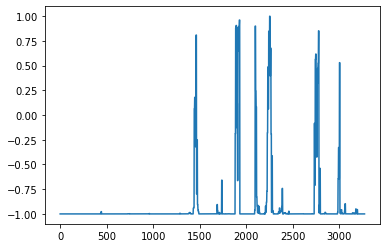

2020-11-06 18:25:03,993	INFO (unknown file):0 -- gc.collect() freed 16 refs in 0.22851723805069923 seconds


In [79]:
pd.DataFrame(actions)[1].plot()

SAC with a reward function of the diff between cumulative returns 

In [4]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 250
config["timesteps_per_iteration"] = 1000
config["buffer_size"] = 20000
config["n_step"] = 10

config['Q_model']['fcnet_hiddens'] = [50, 50]
config['policy_model']['fcnet_hiddens'] = [50, 50]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':200, 'start':'2008-01-02', 'end':'2018-12-31'}

In [75]:

def load_data(price_source='Alpaca_Equity_daily',tickers=['SPY','QQQ'],start='2008-01-02',end='2010-01-02'):
    '''Returned price data to use in gym environment'''
    ## Load data 
    ## Each dataframe will have columns date and a collection of fields 
    if price_source in ['Alpaca_Equity_daily', 'Alpaca_Equity_minute', 'Quandl_Futures_daily']:
        price_df = []
        a = Arctic('localhost')
        lib = a[price_source]
        for t in tickers:
            df1 = lib.read(t).set_index('date').loc[start:end]
            price_df.append(df1[['Open','Volume']])
    if price_source in ['csvdata']:
        price_df = []
        for t in tickers:
            df1 = pd.read_csv('csvdata/{}.csv'.format(t)).set_index('date').loc[start:end]
            price_df.append(df1)
    ## Merge data 
    ## Reference dataframe is taken from the first ticker read where the column labels are assumed to be the same
    if len(price_df) > 0:
        ref_df = price_df[0]
        ref_df_columns = price_df[0].columns
        for i in range(1,len(price_df)):
            ref_df = ref_df.merge(price_df[i], how='outer', on='date',)
        merged_df = ref_df.sort_values(by='date').fillna(0)
    ## Prepare price tensor for observation space 
    price_tensor = np.zeros(shape=(merged_df.shape[0],len(ref_df_columns),len(price_df)))
    for count in range(len(price_df)):
        price_tensor[:,:,count] = merged_df.values[:,len(ref_df_columns)*count:len(ref_df_columns)*(count+1)]
    
    return {'dates':merged_df.index, 'fields':ref_df_columns, 'data':price_tensor }


class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data
        price_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        self.dates = price_data['dates']
        self.fields = price_data['fields']
        self.pricedata = price_data['data']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_features = len(self.fields) * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at open, use log return of open price in the following day 
        next_day_log_return = self.pricedata[self.index+1,0,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [action], axis=0)
        today_portfolio_return = np.sum(action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        if pd.Series(self.log_return_series).size > 100: 
            recent_series = pd.Series(self.log_return_series)[-100:]
            whole_series = pd.Series(self.log_return_series)
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = 0
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        price_lookback = self.pricedata[self.index-self.lookback:self.index,:,:].reshape(self.lookback,-1)
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        self.observation = np.concatenate( (price_lookback,  metrics,
                                            self.position_series[self.index-self.lookback:self.index]), axis=1)
            
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        
        self.metric = 0                    
        self.index = self.lookback
        # Observation join the price, metric and position 
        price_lookback = self.pricedata[:self.index,:,:].reshape(self.lookback,-1)
        metrics = np.vstack((self.log_return_series, self.metric_series)).transpose()
        self.observation = np.concatenate((price_lookback, metrics, self.position_series), axis=1)
        
        return self.observation
    
    
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995
        tcost = turnover * np.log(fees)
        return tcost 


In [76]:

# Train agent 
agent = SACTrainer(config, Equitydaily)

2020-10-19 13:28:35,902	WARNING sac_tf_policy.py:36 -- When not using a state-preprocessor with SAC, `fcnet_hiddens` will be set to an empty list! Any hidden layer sizes are defined via `policy_model.fcnet_hiddens` and `Q_model.fcnet_hiddens`.
2020-10-19 13:28:38,113	INFO trainable.py:252 -- Trainable.setup took 75.004 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-10-19 13:28:38,115	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [77]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':200, 'start':'2008-01-02', 'end':'2020-12-31'})

In [78]:
agent.restore('checkpoint_13272/checkpoint-13272')

2020-10-19 13:29:54,867	INFO trainable.py:481 -- Restored on 155.198.192.44 from checkpoint: checkpoint_13272/checkpoint-13272
2020-10-19 13:29:54,868	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 13272, '_timesteps_total': None, '_time_total': 14658.747411251068, '_episodes_total': 15700}


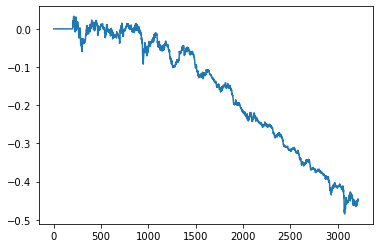

In [79]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    action = agent.compute_action(state)
    #action = np.array([0,0,0,1,0,0,0])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()

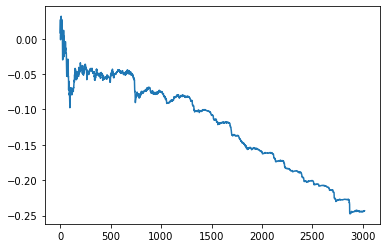

In [80]:
pd.Series(reward_list).cumsum().plot()

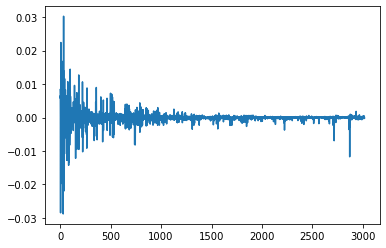

In [81]:
pd.Series(reward_list).plot()

In [61]:
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return

In [66]:
max_drawdown(pd.Series(env.log_return_series))

-0.4394242243444886

In [67]:
annual_return(pd.Series(env.log_return_series))

-0.03626487255199695